# 龙格库塔法四阶实现

## 简单介绍

我的表达可能不是很准确，在我的理解下龙格库塔法是求解微分方程时用到的一种由给定初值求解微分方程近似解的算法。龙格库塔法一阶是入门微积分时学的欧拉法（好像是入门时候学的，具体我记不太清了），这学期学“车辆研发模拟工具”这门课时学得更深入的是四阶。因为上周彻底把那个算法搞完了，这里趁热乎再用Python实现一遍。

In [1]:
%matplotlib inline
from matplotlib import pyplot
from math import pi

In [2]:
# 各个参数
P = 500
I = 200
J = 80.1
uL = 0.1
uB = 0.45
nB = 2
nK = 2
dK = 30
r_eff = 320
nn = 1000
kn = 4700
max_n = 5000
nomi_P = 523.6
Ts = 0.01

# 制动器压强设置
zp1 = 0
zp2 = 10
zp3 = 11
zp4 = 25
zp5 = 26
zp6 = 30
rd1 = 0
rd2 = 0
rd3 = 30
rd4 = 30
rd5 = 0
rd6 = 0

# 转速调整
zp7 = 0
zp8 = 5
zp9 = 6
zp10 = 30
rn1 = 0
rn2 = 0
rn3 = 1500
rn4 = 1500

In [3]:
# 时间离散化
Nt = int((zp10 - zp7)/Ts + 1)
t = []
t.append(zp7)
for i in range(Nt):
    if i < Nt-1:
        t.append(t[i]+Ts)

In [4]:
# 转速单位换算函数
def rpm2radps(orig_n):
    return orig_n*2*pi/60

def radps2rpm(orig_n):
    return orig_n*60/2/pi

# 转速调整函数
def ref(t):
    if t < zp8:
        return rn1 + (rn2 - rn1)/(zp8 - zp7)*(t - zp7)
    elif t < zp9:
        return rn2 + (rn3 - rn2)/(zp9 - zp8)*(t - zp8)
    else:
        return rn3 + (rn4 - rn3)/(zp10 - zp9)*(t - zp9)
    
# 压强调整函数
def ist_p(t):
    if t < zp2:
        return rd1
    elif t < zp3:
        return rd2
    elif t < zp4:
        return rd3
    elif t < zp5:
        return rd4
    elif t < zp6:
        return rd5
    else:
        return rd6
    
# 转矩控制函数
def n2M(ist_n, t):
    # 限制区间（此处转矩为负的情况省略了，以后有兴趣可以加上）
    if ist_n < nn:
        max_M = 3e4/pi*(nomi_P/nn)
    elif ist_n<kn:
        max_M = 3e4/pi*(nomi_P/ist_n)
    else:
        max_M = 3e4/pi*(nomi_P - nomi_P*(ist_n-kn)/(max_n-kn))/ist_n
    
    # 积分部分时间累积
    if t<zp8:
        Nachstellzeit = t - zp7
    elif t<zp9:
        Nachstellzeit = t - zp8
    else:
        Nachstellzeit = t - zp9
    
    # PI控制器
    e = rpm2radps(ref(t))-rpm2radps(ist_n)
    u = P*e + I*e*Nachstellzeit
    if u>max_M:
        return max_M
    else:
        return u

In [5]:
# 转矩、转速和标准转速的处理
M = []
ist_n = []
ist_n.append(0)
ref_n = []

def dn(ist_n, t):
    return 1/J*(n2M(ist_n, t) - 2*uL*rpm2radps(ist_n) - nB*uB*nK*(ist_p(t)*1e5)*pi*(dK*dK*1e-6)/4*r_eff*1e-3)

for i in range(Nt):
    M.append(n2M(ist_n[i], t[i]))
    k1 = radps2rpm(Ts*dn(ist_n[i], t[i]))
    k2 = radps2rpm(Ts*dn(ist_n[i]+k1/2, t[i]+Ts/2))
    k3 = radps2rpm(Ts*dn(ist_n[i]+k2/2, t[i]+Ts/2))
    k4 = radps2rpm(Ts*dn(ist_n[i]+k3, t[i]+Ts))
    if i<Nt-1:
        ist_n.append(ist_n[i] + (k1+2*k2+2*k3+k4)/6)
    ref_n.append(ref(t[i]))

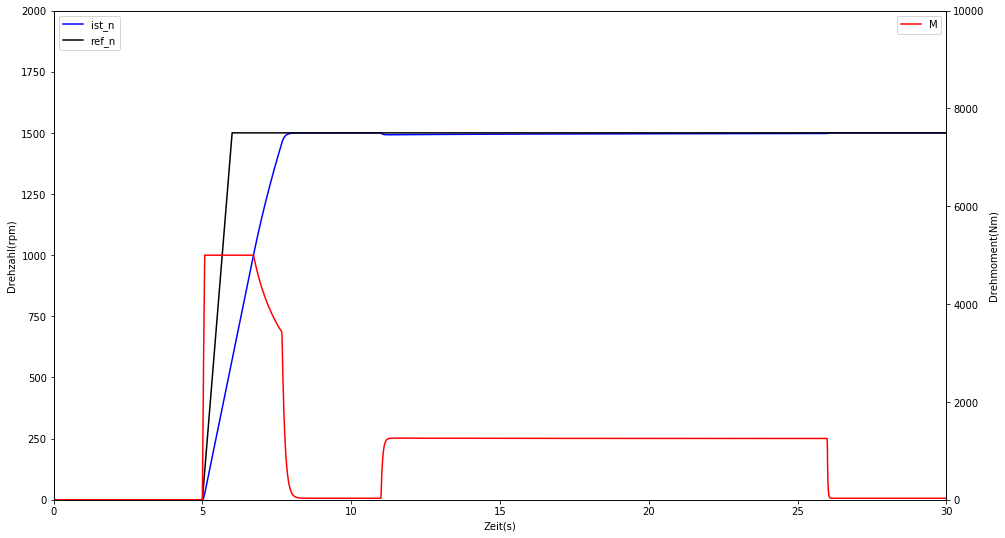

In [7]:
fig = pyplot.figure(figsize=(16, 9))

ax1 = fig.add_subplot(111)
ax1.plot(t, ist_n, 'b', label='ist_n')
ax1.plot(t, ref_n, 'k', label='ref_n')
ax1.set_xlabel('Zeit(s)')
ax1.set_xlim(zp7, zp10)
ax1.set_ylabel('Drehzahl(rpm)')
ax1.set_ylim(0, 2000)
pyplot.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(t, M, 'r', label='M')
ax2.set_ylabel('Drehmoment(Nm)')
ax2.set_ylim(0, 10000)
pyplot.legend(loc='upper right')

pyplot.show()